Import

In [1]:
import cv2 as cv
from skimage import color, io, img_as_float
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import entropy, skew, kurtosis

import re
from pathlib import Path
from itertools import product
from collections import deque
import copy

from tqdm import tqdm
import os
import glob
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.measure import regionprops, label

# from fungsi import imgshow, subplots,  make_frame, make_round_frame, crop_bottom, clahe, cca, cca_dist, otsu, convex_hull, rg_corner, kernel2, kernel3, kernel5, kernel9, masking01, masking02, glcm_lbp, build_dataset, build_dataset02, train_svm_model, remove_pad, body_mask

Fungsi

In [2]:
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
kernel5 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
kernel9 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))

# =====================================================================================================================================================================================================
#Fungsi menampilkan gambar
# =====================================================================================================================================================================================================
def imgshow(input, msg=''):
  plt.imshow(input, cmap='gray')
  plt.title(msg)
  # plt.grid()
  plt.show()

def imgshow1(input, msg=''):
  plt.imshow(input, cmap='gray')
  plt.title(msg)
  # plt.grid()

  #vertical line pada plot
  plt.axvline(x=10, color='red', linewidth=1)
  plt.axvline(x=115, color='red', linewidth=1)
  plt.axvline(x=145, color='red', linewidth=1)
  plt.axvline(x=245, color='red', linewidth=1)

  #horizontal line pada plot
  plt.axhline(y=15, color='red', linewidth=1)
  # plt.axhline(y=240, color='red', linewidth=1)
  plt.show()

def histogram(input):
  plt.figure(figsize=(6,4))
  plt.hist(input.ravel(), bins=256, range=(0, 256))
  plt.title("Histogram Grayscale")
  plt.xlabel("Intensitas")
  plt.ylabel("Jumlah Piksel")
  plt.show()

#===============================================================================================================================================================================================================
#===============================================================================================================================================================================================================
def subplots(images, titles=None):
    n = len(images)
    cols = 4
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    # Flatten agar mudah di-loop
    axs = axs.flatten()

    for i in range(len(axs)):

        if i < n:   # ada gambar
            axs[i].imshow(images[i], cmap='gray')

            # jika titles tersedia
            if titles is not None:
                axs[i].set_title(titles[i])
            else:
                axs[i].set_title(f"Citra {i+1}")

            axs[i].axis("off")

        else:       # subplot kosong
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()




#=========================================================================================================================================================================================================
# Fungsi membuat pigura (frame) dengan sudut melengkung (rounded corners)
#=========================================================================================================================================================================================================
def make_round_frame(
        input_arr, 
        top=10, bottom=10, left=10, right=10,
        
        # --- A. RADIUS SUDUT LUAR (Outer Corners) ---
        rad_tl=50,  # Top-Left Luar
        rad_tr=50,  # Top-Right Luar
        rad_bl=0,  # Bottom-Left Luar
        rad_br=0,  # Bottom-Right Luar
        
        # --- B. RADIUS SUDUT TENGAH (Gap/Inner Corners) ---
        # Sudut di sisi KIRI celah (milik panel kiri)
        rad_gap_tl=0, # Gap Top-Left
        rad_gap_bl=15, # Gap Bottom-Left
        
        # Sudut di sisi KANAN celah (milik panel kanan)
        rad_gap_tr=0, # Gap Top-Right
        rad_gap_br=15, # Gap Bottom-Right
        
        mid_gap=20):
    """
    Membuat mask pigura dengan kontrol penuh atas 8 sudut (4 luar, 4 dalam).
    """
    H, W = input_arr.shape[:2]
    mask = np.zeros((H, W), dtype=np.uint8)

    # --- FUNGSI HELPER: Gambar Kotak dengan 4 Radius Spesifik ---
    def draw_box(img, x0, y0, x1, y1, r_top_left, r_top_right, r_btm_left, r_btm_right):
        if x0 >= x1 or y0 >= y1: return

        # 1. Dasar Kotak Putih Penuh
        cv.rectangle(img, (x0, y0), (x1-1, y1-1), 1, -1)

        # 2. Fungsi memproses 1 sudut (hapus tajam -> gambar bulat)
        def process_corner(corner_name, r):
            if r <= 0: return
            # Batasi radius maksimal agar tidak error
            max_r = min(y1 - y0, x1 - x0) // 2
            r = min(r, max_r)
            
            # Koordinat penghapusan (hitam) dan lingkaran (putih)
            if corner_name == 'tl':
                cv.rectangle(img, (x0, y0), (x0 + r, y0 + r), 0, -1)
                cv.circle(img, (x0 + r, y0 + r), r, 1, -1, cv.LINE_AA)
            elif corner_name == 'tr':
                cv.rectangle(img, (x1 - r - 1, y0), (x1 - 1, y0 + r), 0, -1)
                cv.circle(img, (x1 - r - 1, y0 + r), r, 1, -1, cv.LINE_AA)
            elif corner_name == 'bl':
                cv.rectangle(img, (x0, y1 - r - 1), (x0 + r, y1 - 1), 0, -1)
                cv.circle(img, (x0 + r, y1 - r - 1), r, 1, -1, cv.LINE_AA)
            elif corner_name == 'br':
                cv.rectangle(img, (x1 - r - 1, y1 - r - 1), (x1 - 1, y1 - 1), 0, -1)
                cv.circle(img, (x1 - r - 1, y1 - r - 1), r, 1, -1, cv.LINE_AA)

        # 3. Eksekusi ke 4 sudut
        process_corner('tl', r_top_left)
        process_corner('tr', r_top_right)
        process_corner('bl', r_btm_left)
        process_corner('br', r_btm_right)

    # --- LOGIKA UTAMA ---
    y0_frame = top
    y1_frame = H - bottom
    x0_frame = left
    x1_frame = W - right

    if mid_gap <= 0:
        # Jika tidak ada celah, abaikan radius gap/inner
        draw_box(mask, x0_frame, y0_frame, x1_frame, y1_frame,
                 rad_tl, rad_tr, rad_bl, rad_br)
    else:
        # Hitung koordinat dua panel
        center_x = W // 2
        half_gap = mid_gap // 2
        
        # Batas Kanan Panel Kiri
        x1_left_panel = center_x - half_gap
        # Batas Kiri Panel Kanan
        x0_right_panel = center_x + half_gap + (mid_gap % 2)

        # 1. GAMBAR PANEL KIRI
        #    Sudut: TL(Luar), TR(Gap-TL), BL(Luar), BR(Gap-BL)
        draw_box(mask, 
                 x0_frame, y0_frame, x1_left_panel, y1_frame,
                 r_top_left  = rad_tl,      # Sudut Luar
                 r_top_right = rad_gap_tl,  # Sudut Dalam (atas)
                 r_btm_left  = rad_bl,      # Sudut Luar
                 r_btm_right = rad_gap_bl)  # Sudut Dalam (bawah)

        # 2. GAMBAR PANEL KANAN
        #    Sudut: TL(Gap-TR), TR(Luar), BL(Gap-BR), BR(Luar)
        draw_box(mask, 
                 x0_right_panel, y0_frame, x1_frame, y1_frame,
                 r_top_left  = rad_gap_tr,  # Sudut Dalam (atas)
                 r_top_right = rad_tr,      # Sudut Luar
                 r_btm_left  = rad_gap_br,  # Sudut Dalam (bawah)
                 r_btm_right = rad_br)      # Sudut Luar

    return mask * 255


#===========================================================================================================================================================================================================
# Fungsi masking tubuh  
#====================================================================================================================================================================================   
def body_mask(input):
    # 1. Inversi Citra (Hitam jadi Putih agar terdeteksi)
    inverted_img = cv.bitwise_not(input)

    # 2. Analisis Komponen untuk menemukan area terbesar
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted_img, connectivity=8)

    # Cek apakah ada objek yang terdeteksi
    if num_labels > 1:
        
        # Cari index dari komponen dengan area terbesar (selain background)
        areas = stats[1:, cv.CC_STAT_AREA]
        max_label_idx = np.argmax(areas) + 1  
        
        # print(f"Area terbesar ditemukan pada label {max_label_idx} dengan luas: {areas[max_label_idx-1]} px")

        # 3. Isolasi Area Terbesar
        largest_component_mask = (labels == max_label_idx).astype("uint8") * 255
        
        # --- PROSES MODIFIKASI DIMULAI DARI SINI ---
        
        # A. Cari Kontur dari mask komponen terbesar
        contours, _ = cv.findContours(largest_component_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Ambil kontur (karena mask cuma 1 objek, ambil index 0)
            cnt = contours[0]
            hull = cv.convexHull(cnt)
            
            # B. Buat Gambar Kosong untuk Hull Solid
            hull_solid = np.zeros_like(largest_component_mask)
            
            # C. Gambar Hull sebagai BLOK PADAT (thickness = -1)
            cv.drawContours(hull_solid, [hull], -1, 255, thickness=-1)
            
            # D. POTONG 25px KE DALAM (EROSI)
            # Rumus ukuran kernel: (Jumlah_Potong * 2) + 1
            # Untuk potong 25px -> Kernel size = (25*2)+1 = 51
            pixel_cut = 10
            kernel_size = (pixel_cut * 2) + 1
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            
            # Lakukan Erosi
            largest_eroded = cv.erode(hull_solid, kernel, iterations=1)

    else:
        print("Tidak ada objek hitam ditemukan.")
    
    return largest_eroded


#=======================================================================================================================================================================================================
#Fungsi CLAHE ========================================================================================================================================================================================================
def clahe(input, clipLimit=2.0, tileGridSize=(8,8)):
  #CLAHE object (arguments are optional).
  clahe = cv.createCLAHE(clipLimit, tileGridSize)
  # clahe = cv.createCLAHE(clipLimit=20.0, tileGridSize=(2,2))
  # clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
  output = clahe.apply(input)

  return output

#=======================================================================================================================================================================================================
#Fungsi Otsu ========================================================================================================================================================================================================
def otsu(input,t1=0,t2=255):
   ret, output = cv.threshold(input,t1,t2,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
  #  ret, output = cv.threshold(input,t1,t2,cv.THRESH_OTSU)
  #  ret, output = cv.threshold(input,t1,t2,cv.THRESH_BINARY_INV)

   return ret, output


#======================================================================================================================================================================================================
#Fungsi CCA =======================================================================================================================================================================================================
def cca(input, connectivity=8):
  # CCA
  num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(input, connectivity=8)

  # Ambil area setiap komponen, skip index 0 (background)
  areas = stats[1:, cv.CC_STAT_AREA]

  # Ambil 2 komponen terbesar
  largest_two = np.argsort(areas)[-2:]   # index relatif terhadap stats[1:]
                                          
  # Buat mask baru kosong
  cca_mask = np.zeros_like(input)

  # Isi mask dengan dua komponen terbesar
  for idx in largest_two:
    cca_mask[labels == (idx + 1)] = 255

  return cca_mask

#======================================================================================================================================================================================================
#Fungsi CCA + jarak
#=======================================================================================================================================================================================================
def cca_dist(input_image, connectivity=8):
    """
    Memilih 2 komponen yang:
    1. Cukup BESAR (masuk top 5 largest)
    2. Paling DEKAT dengan titik pusat gambar
    """
    # 1. Connected Components Analysis
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(input_image, connectivity=connectivity)

    # Jika tidak ada komponen (hanya background), kembalikan gambar kosong
    if num_labels <= 1:
        return np.zeros_like(input_image)

    # 2. Tentukan Titik Pusat Gambar
    h, w = input_image.shape[:2]
    img_center_x, img_center_y = w // 2, h // 2
    
    # 3. Kumpulkan Data Kandidat (Index, Area, Jarak ke Pusat)
    candidates = []
    
    # Loop mulai dari 1 (skip background 0)
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        
        # Hitung jarak Euclidean dari centroid komponen ke pusat gambar
        c_x, c_y = centroids[i]
        distance = math.sqrt((c_x - img_center_x)**2 + (c_y - img_center_y)**2)
        
        candidates.append({
            'idx': i,
            'area': area,
            'distance': distance
        })

    # 4. STRATEGI SELEKSI (2 TAHAP)
    
    # TAHAP A: Urutkan berdasarkan AREA terbesar dulu
    # Kita ambil Top-N (misal 5) terbesar. 
    # Tujuannya: Memastikan kita tidak memilih titik noise kecil walau posisinya pas di tengah.
    candidates.sort(key=lambda x: x['area'], reverse=True)
    top_candidates = candidates[:5]  # Ambil 5 kandidat terbesar saja

    # TAHAP B: Dari kandidat besar itu, urutkan berdasarkan JARAK terdekat ke pusat
    top_candidates.sort(key=lambda x: x['distance'], reverse=False)
    
    # Ambil 2 Pemenang (Terdekat ke pusat dari para raksasa)
    final_selection = top_candidates[:2]

    # 5. Rekonstruksi Mask
    cca_mask = np.zeros_like(input_image)
    
    for item in final_selection:
        idx = item['idx']
        # Isi mask dengan komponen yang terpilih
        cca_mask[labels == idx] = 255

    return cca_mask

#=====================================================================================================================================================================================================
#Fungsi Convex Hull 
# ====================================================================================================================================================================================================
def convex_hull(input):

    num_255 = np.sum(input == 255)
    num_0 = np.sum(input == 0)
    # print(num_255, num_0)

    contours, _ = cv.findContours(input, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    hull_mask = np.zeros_like(input)

    for cnt in contours:
        hull = cv.convexHull(cnt)
        cv.drawContours(hull_mask, [hull], -1, 255, -1)
    

    # if num_255 < num_0:
    #     contours, _ = cv.findContours(input, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    #     hull_mask = np.zeros_like(input)

    #     for cnt in contours:
    #         hull = cv.convexHull(cnt)
    #         cv.drawContours(hull_mask, [hull], -1, 255, -1)
    # else:
    #     hull_mask = input

    return hull_mask

#=============================================================================================================================================================================================================
# Fungsi remove padding
# ============================================================================================================================================================================================================
def remove_pad(input, padding_px=12):
    # 1. Ambil dimensi gambar yang sudah dipadding
    h, w = input.shape[:2] # height, width

    # 2. Lakukan Slicing (Pemotongan)
    # Rumusnya: image[y_start : y_end, x_start : x_end]
    # Kita mulai dari pixel ke-10 (melewati border atas/kiri)
    # Kita berhenti di pixel total dikurang 10 (membuang border bawah/kanan)
    original_image = input[padding_px : h - padding_px, padding_px : w - padding_px]

    return original_image


#============================================================================================================================================================================================================
# Fungsi Masking Komplit
# ===========================================================================================================================================================================================================

def masking01(input):#EXPIRED
  #Proses pre-proses==============================================================================================
  # Membuat frame mask dengan rounded corners
  frame = make_round_frame(
  input,
  top=10, bottom=30, left=10, right=10,
  mid_gap=20,
  # LUAR: Kiri siku-siku, Kanan bulat
  rad_tl=60, rad_bl=0,   
  rad_tr=60, rad_br=0, 
  # DALAM: Kiri bulat, Kanan siku-siku
  rad_gap_tl=0, rad_gap_bl=60, 
  rad_gap_tr=0,  rad_gap_br=60
  )

  # Crop bottom
  bott = crop_bottom(input)
  if bott == None:
      pre = input
  else:
      pre = bott["result"]

  #Proses Enchance dan Segmentasi==================================================================================
  out_clahe = clahe(pre) #CLAHE 
  _, out_otsu = otsu(out_clahe,0,255)   #Otsu thresholding
  morf = out_otsu 
  morf = cv.bitwise_and(morf,frame) #frame mask
  morf = cv.morphologyEx(morf, cv.MORPH_CLOSE, kernel9) #closing  
  morf = cv.erode(morf,kernel2,iterations = 2) #erosi  
  morf = cv.dilate(morf,kernel3,iterations = 5) #dilasi 1  
  # morf = cv.morphologyEx(morf, cv.MORPH_OPEN, kernel2) #opening  
  morf = cca(morf) #cca 1  
  morf = cv.dilate(morf,kernel2,iterations = 2) #dilasi 2  
  morf = cv.morphologyEx(morf, cv.MORPH_CLOSE, kernel9) #closing  
  morf = cca(morf) #cca 2  
  morf = convex_hull(morf) #convex hull
  output = morf

  return output


def masking02(input):#BARU
  
    #Proses pre-proses==============================================================================================
    blur = cv.GaussianBlur(input, (9,9), 0)
    cl = clahe(blur)
    _, otsuu = otsu(cl)

    frame = make_round_frame(
    otsuu,
    top=0, bottom=0, left=0, right=0,
    mid_gap=35,
    # LUAR: Kiri siku-siku, Kanan bulat
    rad_tl=0, rad_bl=0,   
    rad_tr=0, rad_br=0, 
    # DALAM: Kiri bulat, Kanan siku-siku
    rad_gap_tl=0, rad_gap_bl=0, 
    rad_gap_tr=0,  rad_gap_br=0
    )

    otsuu = cv.bitwise_and(frame,otsuu)

    padded = cv.copyMakeBorder(
        otsuu, 
        12, 12, 12, 12, 
        cv.BORDER_CONSTANT, 
        value=[255] 
    )

    # invert = cv.bitwise_not(padded) #OPSIONAL
    largest = body_mask(padded)
    out = cv.bitwise_and(padded,largest)
    morf = cv.dilate(morf,kernel5,iterations = 3) 
    out = cca_dist(out)

    #Morfologi
    morf = out
    # morf = cv.erode(out,kernel3,iterations = 1) 
    # morf = cv.dilate(morf,kernel5,iterations = 3) 
    # morf = cca(morf)
    morf = convex_hull(morf)
    output = remove_pad(morf)

    return output


#==========================================================================================================================================================================================
#Fungsi Ekstraksi fitur GLCM dan LBP ===========================================================================================================================================================================================
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import entropy

def glcm_lbp(image, mask):
    """
    Ekstraksi fitur khusus Tekstur: GLCM dan LBP.
    
    Args:
        image: Grayscale image (asli).
        mask: Mask binary (putih = paru-paru).
        
    Returns:
        dict: Dictionary berisi nilai fitur.
    """
    
    # --- 0. PRE-PROCESSING ROI (Region of Interest) ---
    # Kita crop kotak bounding box dulu untuk mempercepat komputasi
    x, y, w, h = cv.boundingRect(mask)
    
    # Crop citra dan mask
    roi_img = image[y:y+h, x:x+w]
    roi_mask = mask[y:y+h, x:x+w]
    
    # Masking pixel: Pastikan background benar-benar 0
    masked_roi = cv.bitwise_and(roi_img, roi_img, mask=roi_mask)
    
    features = {}

    # ==========================================
    # 1. GLCM (Gray-Level Co-occurrence Matrix)
    # ==========================================
    # Parameter GLCM:
    # distances=[1] -> piksel bertetangga langsung (jarak 1)
    # angles=[0, 45, 90, 135] -> Diambil rata-ratanya agar rotation invariant
    # levels=256 -> Menggunakan seluruh level abu-abu
    
    # Catatan: Area background (hitam/0) akan membuat nilai di pojok kiri atas matriks (0,0) sangat tinggi.
    # Ini wajar dalam segmentasi objek, namun properti tekstur relatif tetap valid untuk area ROI.
    
    glcm = graycomatrix(masked_roi, distances=[1], 
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=256, 
                        symmetric=True, normed=True)

    # Kita ambil rata-rata (mean) dari 4 sudut tadi
    features['glcm_contrast']      = np.mean(graycoprops(glcm, 'contrast'))
    features['glcm_dissimilarity'] = np.mean(graycoprops(glcm, 'dissimilarity'))
    features['glcm_homogeneity']   = np.mean(graycoprops(glcm, 'homogeneity'))
    features['glcm_energy']        = np.mean(graycoprops(glcm, 'energy'))
    features['glcm_correlation']   = np.mean(graycoprops(glcm, 'correlation'))
    features['glcm_ASM']           = np.mean(graycoprops(glcm, 'ASM'))

    # ==========================================
    # 2. LBP (Local Binary Pattern)
    # ==========================================
    # Parameter LBP Standard untuk medis:
    # P = 8 (jumlah titik tetangga), R = 1 (radius)
    # Method = 'uniform' (Mengurangi jumlah fitur menjadi 59 bin histogram yang bermakna)
    
    P = 8
    R = 1
    lbp_image = local_binary_pattern(roi_img, P, R, method='uniform')
    
    # PENTING:
    # Kita tidak mengambil 'rata-rata nilai LBP' karena tidak bermakna.
    # Fitur LBP adalah HISTOGRAM dari nilai-nilai LBP tersebut.
    
    # Ambil nilai LBP HANYA di dalam mask (abaikan background)
    lbp_valid_values = lbp_image[roi_mask > 0]
    
    if len(lbp_valid_values) > 0:
        # Hitung Histogram LBP (n_bins untuk uniform P=8 adalah 10 s.d 59 tergantung implementasi, biasanya P*(P-1)+3)
        # Kita simplifikasi dengan mengambil statistik dari histogramnya
        
        hist, _ = np.histogram(lbp_valid_values, bins=np.arange(0, P + 3), density=True)
        
        # Opsi A: Ambil Energi dan Entropi dari Histogram LBP (Scalar features)
        # Energi tinggi = tekstur seragam/flat
        # Entropi tinggi = tekstur acak/kompleks
        features['lbp_energy'] = np.sum(hist ** 2)
        features['lbp_entropy'] = entropy(hist)
        
        # Opsi B: Jika Anda mau setiap bin histogram jadi fitur (misal untuk SVM/Neural Network)
        # Uncomment baris ini jika ingin fitur detail (lbp_0, lbp_1, ... lbp_9)
        # for i, val in enumerate(hist):
        #     features[f'lbp_hist_{i}'] = val
            
    else:
        features['lbp_energy'] = 0
        features['lbp_entropy'] = 0

    return features



#==========================================================================================================================================================================================
#Fungsi Ekstraksi semua fitur #==========================================================================================================================================================================================
def extract_all_features(image, mask):
    """
    Ekstraksi 5 Jenis Fitur: Intensity, GLCM, LBP, Shape, HOG
    """
    x, y, w, h = cv.boundingRect(mask)
    if w == 0 or h == 0: return None
        
    roi_img = image[y:y+h, x:x+w]
    roi_mask = mask[y:y+h, x:x+w]
    masked_roi = cv.bitwise_and(roi_img, roi_img, mask=roi_mask)
    lung_pixels = roi_img[roi_mask > 0]
    
    features = {}

    # 1. INTENSITY
    if len(lung_pixels) > 0:
        features['int_mean'] = np.mean(lung_pixels)
        features['int_std'] = np.std(lung_pixels)
        features['int_skew'] = skew(lung_pixels)
        features['int_kurtosis'] = kurtosis(lung_pixels)
    else:
        features['int_mean'] = 0; features['int_std'] = 0; features['int_skew'] = 0; features['int_kurtosis'] = 0

    # 2. GLCM
    glcm = graycomatrix(masked_roi, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    features['glcm_contrast'] = np.mean(graycoprops(glcm, 'contrast'))
    features['glcm_dissimilarity'] = np.mean(graycoprops(glcm, 'dissimilarity'))
    features['glcm_homogeneity'] = np.mean(graycoprops(glcm, 'homogeneity'))
    features['glcm_energy'] = np.mean(graycoprops(glcm, 'energy'))
    features['glcm_correlation'] = np.mean(graycoprops(glcm, 'correlation'))
    features['glcm_ASM'] = np.mean(graycoprops(glcm, 'ASM'))

    # 3. LBP
    lbp = local_binary_pattern(roi_img, 8, 1, method='uniform')
    lbp_valid = lbp[roi_mask > 0]
    if len(lbp_valid) > 0:
        hist, _ = np.histogram(lbp_valid, bins=np.arange(0, 11), density=True)
        features['lbp_energy'] = np.sum(hist ** 2)
        features['lbp_entropy'] = entropy(hist)
    else:
        features['lbp_energy'] = 0; features['lbp_entropy'] = 0

    # 4. SHAPE
    lbl_mask = label(roi_mask)
    props = regionprops(lbl_mask)
    if props:
        prop = max(props, key=lambda x: x.area)
        features['shape_solidity'] = prop.solidity
        features['shape_eccentricity'] = prop.eccentricity
        features['shape_extent'] = prop.extent
    else:
        features['shape_solidity'] = 0; features['shape_eccentricity'] = 0; features['shape_extent'] = 0

    # 5. HOG (Resize to fixed size)
    try:
        roi_resized = cv.resize(roi_img, (64, 128))
        fd, _ = hog(roi_resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        features['hog_mean'] = np.mean(fd)
        features['hog_std'] = np.std(fd)
        features['hog_skew'] = skew(fd)
    except:
        features['hog_mean'] = 0; features['hog_std'] = 0; features['hog_skew'] = 0
        
    # Extra: Calcification & Cavity Ratio
    bright_pixels = np.count_nonzero((roi_img > 200) & (roi_mask > 0))
    dark_pixels = np.count_nonzero((roi_img < 50) & (roi_mask > 0))
    lung_area = np.count_nonzero(roi_mask)
    
    features['calc_ratio'] = bright_pixels / lung_area if lung_area > 0 else 0
    features['cavity_ratio'] = dark_pixels / lung_area if lung_area > 0 else 0

    return features

# ========================================================================================================================================================================================================
# FUNGSI MEMBUAT DATASET (LOOPING FOLDER)
# ========================================================================================================================================================================================================

def build_dataset(normal_path, tb_path):
    data_list = []
    
    # List folder dan labelnya
    # Label 0 = Normal, Label 1 = TB
    folders = [(normal_path, 0), (tb_path, 1)]
    
    print("Mulai mengekstrak fitur dari gambar...")
    
    for folder_path, label in folders:
        # Ambil semua jpg/png
        files = glob.glob(os.path.join(folder_path, "*.*"))
        # Filter hanya jpg/png/jpeg
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"  > Memproses folder: {folder_path} ({len(files)} gambar)")
        
        for filepath in files:
            try:
                # 1. Baca Gambar
                img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
                if img is None: continue
                
                # 2. Masking
                final_mask = masking01(img)
                # final_mask = masking02(img)
                
                # 3. Ekstraksi Fitur
                features = glcm_lbp(img, final_mask)
                
                # 4. Tambah Label
                features['label'] = label
                features['filename'] = os.path.basename(filepath)
                
                data_list.append(features)
                
            except Exception as e:
                print(f"    Error pada {filepath}: {e}")

    # Ubah list ke DataFrame Pandas
    df = pd.DataFrame(data_list)
    return df



def build_dataset02(normal_path, tb_path):
    data_list = []
    
    # List folder dan labelnya
    # Label 0 = Normal, Label 1 = TB
    folders = [(normal_path, 0), (tb_path, 1)]
    
    print("Mulai mengekstrak fitur dari gambar...")
    
    for folder_path, label in folders:
        # Ambil semua jpg/png
        files = glob.glob(os.path.join(folder_path, "*.*"))
        # Filter hanya jpg/png/jpeg
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"  > Memproses folder: {folder_path} ({len(files)} gambar)")
        
        for filepath in files:
            try:
                # 1. Baca Gambar
                img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
                if img is None: continue
                
                # 2. Masking
                # final_mask = masking01(img)
                final_mask = masking02(img)
                
                # 3. Ekstraksi Fitur
                features = glcm_lbp(img, final_mask)
                
                # 4. Tambah Label
                features['label'] = label
                features['filename'] = os.path.basename(filepath)
                
                data_list.append(features)
                
            except Exception as e:
                print(f"    Error pada {filepath}: {e}")

    # Ubah list ke DataFrame Pandas
    df = pd.DataFrame(data_list)
    return df


# ======================================================================================================================================================================================================
# BAGIAN 3: BUILD DATASET (Looping)
# ======================================================================================================================================================================================================

def build_dataset_complete(normal_path, tb_path):
    data_list = []
    folders = [(normal_path, 0), (tb_path, 1)]
    
    print("Mulai mengekstrak fitur (Intensity, GLCM, LBP, Shape, HOG)...")
    
    for folder_path, label in folders:
        files = glob.glob(os.path.join(folder_path, "*.*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"  > Memproses folder: {folder_path} ({len(files)} gambar)")
        
        for filepath in files:
            try:
                # 1. Baca Gambar
                img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
                if img is None: continue
                
                # 2. Masking (Final Clean)
                final_mask = masking02(img)
                
                # 3. Ekstraksi Fitur LENGKAP
                features = extract_all_features(img, final_mask)
                
                if features is not None:
                    # 4. Tambah Label & Filename
                    features['label'] = label
                    features['filename'] = os.path.basename(filepath)
                    data_list.append(features)
                
            except Exception as e:
                print(f"    Error pada {filepath}: {e}")

    return pd.DataFrame(data_list)

# ========================================================================================================================================================================================================
# FUNGSI TRAINING SVM
# ========================================================================================================================================================================================================
def train_svm_model(df, output_model_name='model_svm_paru.pkl', output_scaler_name='scaler_paru.pkl'):
    print("\nMemulai proses Training SVM...")
    
    # 1. Pisahkan Fitur (X) dan Target (y)
    # Kita drop kolom non-fitur
    X = df.drop(['label', 'filename'], axis=1)
    y = df['label']
    
    print(f"Fitur yang digunakan: {list(X.columns)}")
    
    # 2. Split Data (80% Training, 20% Testing)
    # stratify=y memastikan rasio Normal:TB di training dan testing seimbang
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Scaling (Standarisasi Data) - WAJIB UNTUK SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 4. Inisialisasi dan Latih Model SVM
    # kernel='rbf' cocok untuk data fitur tekstur yang kompleks
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train_scaled, y_train)
    
    # 5. Evaluasi Hasil
    y_pred = svm_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n--- HASIL TRAINING ---")
    print(f"Akurasi Model: {acc * 100:.2f}%")
    print("\nLaporan Klasifikasi:")
    target_names = ['Normal', 'TB']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Visualisasi Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Kenyataan')
    plt.xlabel('Prediksi Model')
    plt.show()
    
    # 6. Simpan Model & Scaler
    joblib.dump(svm_model, output_model_name)
    joblib.dump(scaler, output_scaler_name)
    print(f"\nModel berhasil disimpan ke: {output_model_name}")
    print(f"Scaler berhasil disimpan ke: {output_scaler_name}")
    print("Siap digunakan untuk klasifikasi!")


def train_svm_model02(df):
    print("MEMULAI TRAINING SVM...")
    
    # 1. Pastikan Label dibuang dari X
    X = df.drop(['label', 'filename'], axis=1)
    y = df['label']
    
    # 2. Split Data (80% Train, 20% Test)
    # random_state=42 agar hasil konsisten
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # PENTING: Pakai .transform, bukan .fit_transform
    
    # 4. Train Model
    model = SVC(kernel='rbf', C=1.0, class_weight='balanced', gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 5. --- CEK KEJUJURAN (EVALUASI GANDA) ---
    
    # A. Tes ke Data Latihan (Buku PR) - Harusnya tinggi
    pred_train = model.predict(X_train_scaled)
    acc_train = accuracy_score(y_train, pred_train)
    
    # B. Tes ke Data Ujian (UN) - Inilah nilai asli
    pred_test = model.predict(X_test_scaled)
    acc_test = accuracy_score(y_test, pred_test)
    
    print(f"LAPORAN PERBANDINGAN:")
    print(f"   Akurasi Training (Hafalan): {acc_train * 100:.2f}%")
    print(f"   Akurasi Testing (Asli):     {acc_test * 100:.2f}%")
    
    print("Detail Laporan Testing:")
    print(classification_report(y_test, pred_test, target_names=['Normal', 'TB']))

    # Analisis Singkat
    diff = acc_train - acc_test
    if acc_test > 0.99:
        print("\n⚠️  PERINGATAN: Akurasi Testing > 99% sangat mencurigakan.")
        print("    Cek apakah ada duplikasi data antara folder Normal dan TB?")
    elif diff > 0.10: # Beda lebih dari 10%
        print(f"\n⚠️  PERINGATAN: Terjadi Overfitting (Selisih {diff*100:.1f}%)")
        print("    Model jago menghafal tapi jelek saat ujian.")
    else:
        print("\n✅ STATUS: Model Sehat (Generalisasi Bagus).")
        
    # Simpan
    joblib.dump(model, 'model_svm_paru_lengkap.pkl')
    joblib.dump(scaler, 'scaler_paru_lengkap.pkl')


Training

In [ ]:
# SETTING LOKASI FOLDER ANDA DISINI
# PATH_NORMAL = "TB_Chest_Radiography_Database/Normal" 
# PATH_TB     = "TB_Chest_Radiography_Database/Tuberculosis"
PATH_NORMAL = "Dataset X-rays/Normal" 
PATH_TB     = "Dataset X-rays/TB"

# Cek folder ada atau tidak
if not os.path.exists(PATH_NORMAL) or not os.path.exists(PATH_TB):
    print("ERROR: Folder dataset tidak ditemukan!")
    print(f"Pastikan folder '{PATH_NORMAL}' dan '{PATH_TB}' sudah ada.")
    
    # (Opsional) Buat folder dummy agar kode tidak error saat pertama kali dijalankan
    os.makedirs(PATH_NORMAL, exist_ok=True)
    os.makedirs(PATH_TB, exist_ok=True)
    print("Folder telah dibuat otomatis. Silakan isi dengan gambar lalu jalankan ulang.")

else:
    # 1. Buat Dataset dari gambar (Menggunakan fungsi baru build_dataset_complete)
    df_dataset = build_dataset_complete(PATH_NORMAL, PATH_TB)
    # audit_data_leakage(df_dataset)
    
    if len(df_dataset) > 0:
        # Simpan dataset ke CSV
        output_csv = "data_training_features_lengkap.csv"
        df_dataset.to_csv(output_csv, index=False)
        print(f"Data fitur disimpan ke '{output_csv}'")
        print(df_dataset.head())
        
        # 2. Latih Model
        train_svm_model(df_dataset)
    else:
        print("Folder kosong atau tidak ada gambar yang berhasil diekstrak!")

Cek hasil per biji

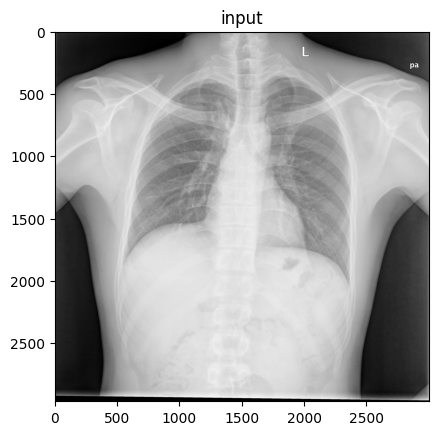

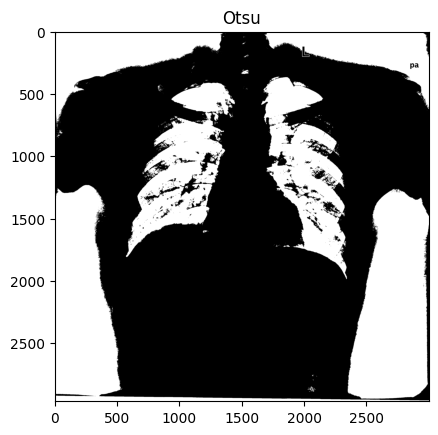

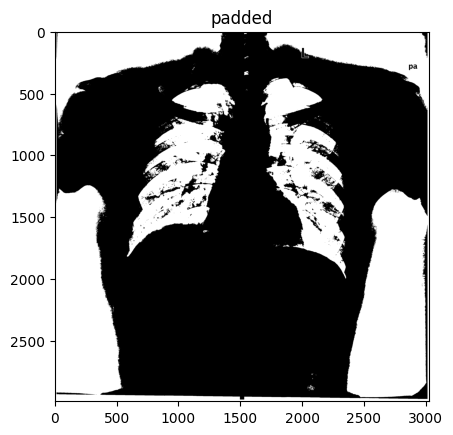

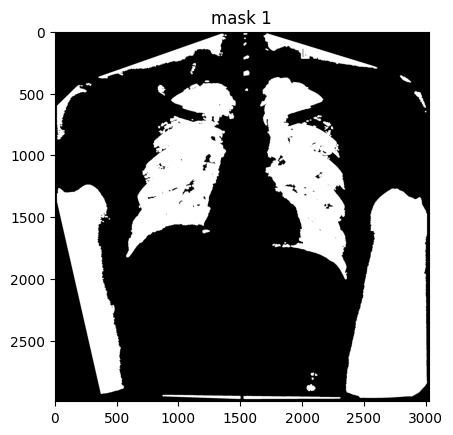

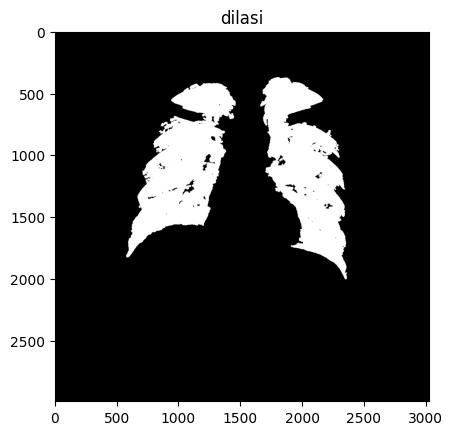

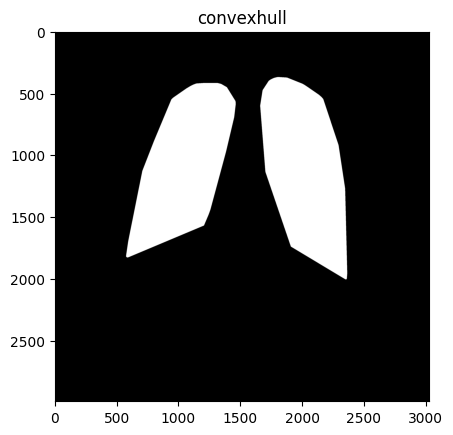

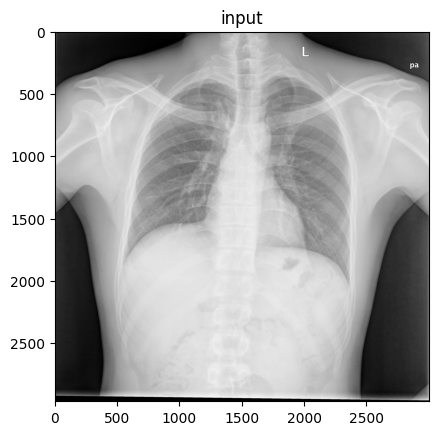

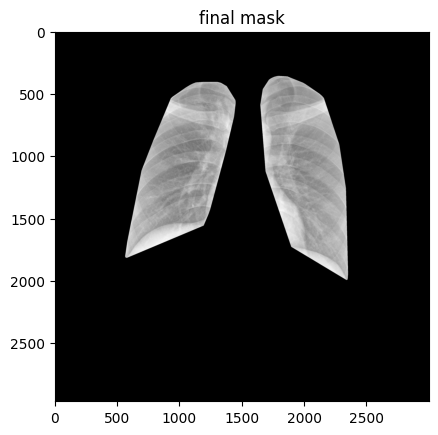

In [6]:
#PATH img Normal 
# path = "Dataset X-rays/Normal/others (1).jpg"
path = "Dataset XR Fawwaz/image/1031.png"

#PATH img TB
# path = "Dataset X-rays/TB/TB.20.jpg"
# path = "training_data/TB/Tuberculosis-239.png" 

image = cv.imread(path, cv.IMREAD_GRAYSCALE)
img = copy.deepcopy(image)
imgshow(img,"input")

# out = masking01(img)
# imgshow(out)
blur = cv.GaussianBlur(img, (3,3), 0)
# imgshow(blur)
cl = clahe(blur)
# imgshow(cl)

_, otsuu = otsu(cl)
imgshow(otsuu,'Otsu')

frame = make_round_frame(
  otsuu,
  top=0, bottom=0, left=0, right=0,
  mid_gap=35,
  # LUAR: Kiri siku-siku, Kanan bulat
  rad_tl=0, rad_bl=0,   
  rad_tr=0, rad_br=0, 
  # DALAM: Kiri bulat, Kanan siku-siku
  rad_gap_tl=0, rad_gap_bl=0, 
  rad_gap_tr=0,  rad_gap_br=0
  )
otsuu = cv.bitwise_and(frame,otsuu)

padded = cv.copyMakeBorder(
    otsuu, 
    12, 12, 12, 12, 
    cv.BORDER_CONSTANT, 
    value=[255] 
)
imgshow(padded,'padded')

# invert = cv.bitwise_not(padded) #OPSIONAL
# imgshow(invert, 'invert')

large = body_mask(padded)
out = cv.bitwise_and(padded,large)
out = cv.dilate(out,kernel5,iterations = 3) 
imgshow(out, "mask 1")

out = cca_dist(out)
imgshow(out,"dilasi")

#Morfologi
morf = out
# morf = cca(morf)
# morf = cv.erode(out,kernel3,iterations = 1) 
# morf = cv.dilate(morf,kernel5,iterations = 3) 
# imgshow(morf, 'dilasi')
morf = convex_hull(morf)
imgshow(morf, 'convexhull')

mask = remove_pad(morf)
masked = cv.bitwise_and(mask,img)
imgshow(img, 'input')
imgshow(masked, 'final mask')

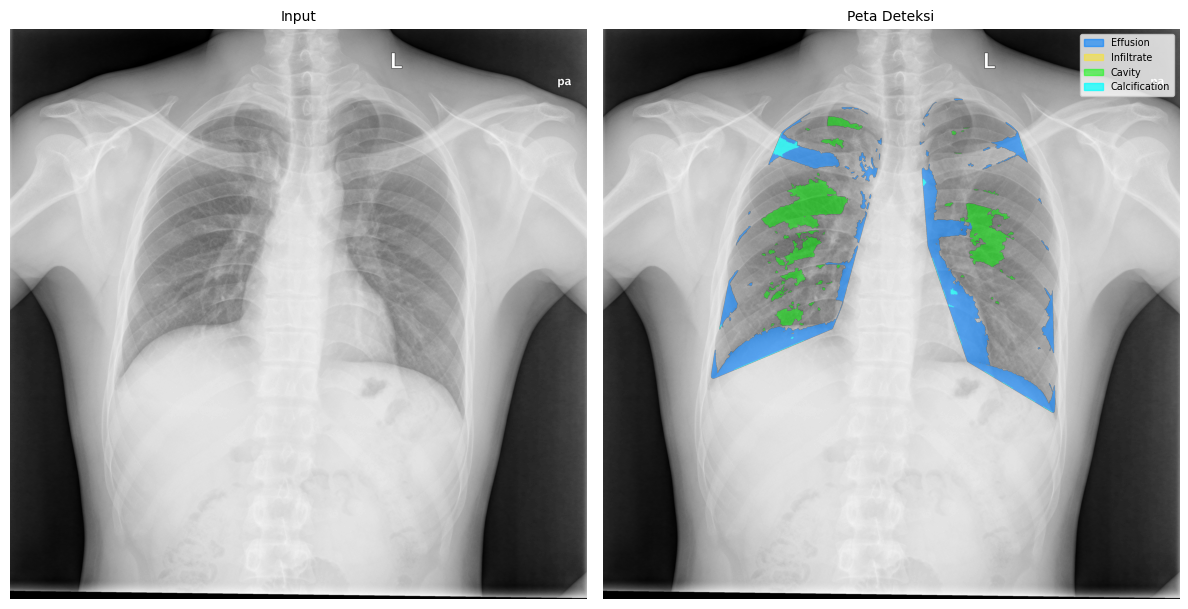

LAPORAN DIAGNOSIS AI: Hasil Segmentasi 001
● [EFFUSION]
  Area       : 18.24%
  Warna Peta : Biru Laut
  Indikasi   : Cairan Pleura (Menutupi Sudut/Bawah Paru)
------------------------------------------------------------
● [CAVITY]
  Area       : 10.43%
  Warna Peta : Hijau
  Indikasi   : Lubang/Kerusakan Jaringan (TBC Lanjut)
------------------------------------------------------------
● [CALCIFICATION]
  Area       : 0.81%
  Warna Peta : Cyan/Biru Muda
  Indikasi   : Jaringan Keras (Bekas Luka Lama)
------------------------------------------------------------
TOTAL INFEKSI: 29.48% dari luas paru.
   STATUS: MODERATE (Perlu Penanganan)



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.segmentation import felzenszwalb
from skimage import img_as_float
from scipy.ndimage import gaussian_filter

# ==========================================
# 1. KONFIGURASI (Tetap Sesuai Request Anda)
# ==========================================
LESION_CONFIG = {
    'Effusion': {  
        'color': [0.0, 0.5, 1.0, 0.6], # Biru Laut
        'color_name': 'Biru Laut',
        'desc': 'Cairan Pleura (Menutupi Sudut/Bawah Paru)',
        'id': 1
    },
    'Infiltrate': {
        'color': [1.0, 0.9, 0.1, 0.5], # Kuning
        'color_name': 'Kuning',
        'desc': 'Bercak Sebar (Infeksi Awal/Aktif)',
        'id': 2
    },
    'Cavity': {
        'color': [0.0, 1.0, 0.0, 0.5], # Hijau
        'color_name': 'Hijau',
        'desc': 'Lubang/Kerusakan Jaringan (TBC Lanjut)',
        'id': 3
    },
    'Calcification': {
        'color': [0.0, 1.0, 1.0, 0.7], # Cyan
        'color_name': 'Cyan/Biru Muda',
        'desc': 'Jaringan Keras (Bekas Luka Lama)',
        'id': 4
    }
}

# ==========================================
# 2. CORE LOGIC (Input: Array Variabel)
# ==========================================
def analyze_lesion_content(img, mask):
    """
    Fungsi inti untuk analisis superpixel.
    Input:
      img  : NumPy Array (Grayscale 0-255)
      mask : NumPy Array (Binary 0-255 atau 0-1)
    Output:
      overlay : Image RGBA untuk visualisasi
      stats   : Dictionary persentase area
    """
    # Validasi Input
    if img is None or mask is None:
        return None, {}
    
    # Pastikan mask berupa boolean untuk indexing
    mask_bool = mask > 0
    
    # Persiapan data untuk Felzenszwalb (butuh float)
    img_float = img_as_float(img)
    img_masked = img_float.copy()
    img_masked[~mask_bool] = 0 # Hitamkan area luar paru

    # Segmentasi Superpixel
    try:
        segments = felzenszwalb(img_masked, scale=40, sigma=0.5, min_size=50, channel_axis=None)
    except TypeError:
        segments = felzenszwalb(img_masked, scale=40, sigma=0.5, min_size=50)

    # Wadah Masker per Penyakit
    masks = {k: np.zeros(img.shape, dtype=float) for k in LESION_CONFIG.keys()}

    # Statistik Dasar Paru (Global)
    lung_pixels = img[mask_bool]
    if len(lung_pixels) == 0: return None, {}
    
    global_mean = np.mean(lung_pixels)
    global_std = np.std(lung_pixels)
    h, w = img.shape

    # Loop setiap segmen superpixel
    unique_segments = np.unique(segments)
    for seg_id in unique_segments:
        if seg_id == 0: continue # Skip background hitam
        
        segment_mask = (segments == seg_id)
        
        # HANYA proses jika segmen mayoritas ada di DALAM mask paru
        # (Mencegah deteksi di area hitam luar paru)
        overlap = np.sum(segment_mask & mask_bool)
        total_seg = np.sum(segment_mask)
        if (overlap / total_seg) < 0.6: 
            continue

        # Ambil pixel asli
        patch_vals = img[segment_mask]
        mean_val = np.mean(patch_vals)
        variance = np.var(patch_vals)

        # --- LOGIKA KLASIFIKASI ---
        
        # 1. Calcification
        if mean_val > (global_mean + 2.0 * global_std):
            masks['Calcification'][segment_mask] = 1.0

        # 2. Effusion (Cair/Homogen)
        elif mean_val > (global_mean + 0.8 * global_std) and variance < 500:
            masks['Effusion'][segment_mask] = 1.0

        # 3. Cavity (Gelap)
        elif mean_val < (global_mean - 0.9 * global_std):
            masks['Cavity'][segment_mask] = 1.0

        # 4. Infiltrate (Kasar)
        elif mean_val > global_mean and variance >= 500:
            masks['Infiltrate'][segment_mask] = 1.0

    # Buat Overlay Visual & Hitung Persentase
    total_lung_area = np.sum(mask_bool)
    stats = {}
    final_overlay = np.zeros((h, w, 4), dtype=float)

    for name, config in LESION_CONFIG.items():
        # Haluskan sedikit biar tidak kotak-kotak
        mask_smooth = gaussian_filter(masks[name], sigma=1.0)
        mask_binary = mask_smooth > 0.1

        # Hitung %
        pixel_count = np.sum(mask_binary)
        percentage = (pixel_count / total_lung_area) * 100
        stats[name] = percentage

        # Warnai Overlay
        if percentage > 0.1:
            final_overlay[mask_binary > 0] = config['color']

    return final_overlay, stats

# ==========================================
# 3. FUNGSI PEMANGGIL (UTAMA)
# ==========================================
def run_tbc_diagnosis(img_input, mask_input, patient_name="Patient Image"):
    """
    Panggil fungsi ini setelah Anda memiliki 'img' dan 'mask'.
    img_input  : Variabel gambar (Grayscale)
    mask_input : Variabel mask (Binary)
    """
    
    # 1. Analisis
    overlay, stats = analyze_lesion_content(img_input, mask_input)
    
    if overlay is None:
        print("Gagal: Mask kosong atau tidak valid.")
        return

    # 2. Visualisasi Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Kiri: Asli
    axes[0].imshow(img_input, cmap='gray')
    axes[0].set_title("Input", fontsize=10)
    axes[0].axis('off')

    # Kanan: Hasil AI
    axes[1].imshow(img_input, cmap='gray')     # Background
    axes[1].imshow(overlay)                    # Overlay Warna
    axes[1].set_title("Peta Deteksi", fontsize=10)
    axes[1].axis('off')

    # Legenda Warna
    patches = [mpatches.Patch(color=v['color'], label=k) for k, v in LESION_CONFIG.items()]
    axes[1].legend(handles=patches, loc='upper right', fontsize='x-small')

    plt.tight_layout()
    plt.show()

    # 3. Cetak Laporan Teks
    print(f"LAPORAN DIAGNOSIS AI: {patient_name}")
    print("=" * 60)

    lesion_found = False
    total_infection = 0

    for name, score in stats.items():
        if score > 0.1: # Threshold minimal 0.1% area
            lesion_found = True
            total_infection += score
            cfg = LESION_CONFIG[name]
            
            print(f"● [{name.upper()}]")
            print(f"  Area       : {score:.2f}%")
            print(f"  Warna Peta : {cfg['color_name']}")
            print(f"  Indikasi   : {cfg['desc']}")
            print("-" * 60)

    if not lesion_found:
        print("HASIL: Paru-paru tampak bersih (Tidak ada lesi signifikan).")
    else:
        print(f"TOTAL INFEKSI: {total_infection:.2f}% dari luas paru.")
        if total_infection > 50:
            print("   STATUS: CRITICAL (Kondisi Sangat Berat)")
        elif total_infection > 20:
            print("   STATUS: MODERATE (Perlu Penanganan)")
        else:
            print("   STATUS: MILD (Infeksi Ringan)")
    
    print("="*60 + "\n")

# ==========================================
# CONTOH CARA MEMASANGNYA DI KODE ANDA
# ==========================================
if __name__ == "__main__":
    # Anggaplah di atas sini ada kode proses segmentasi Anda
    # ...
    # img_result = ... (Hasil resize/clahe Anda)
    # mask_result = ... (Hasil prediksi UNet Anda)
    
    # --- CARA PANGGIL ---
    # Cukup satu baris ini saja:
    run_tbc_diagnosis(img, mask)